#### Michele Meazzini - 635889
# Songs Genre Classifier
This project aims to speed up the process of classifying songs by genre using different types of classification models. Different tecniques of data visualization, preprocessing and classification are involved to achieve the best performances possible in terms of accuracy, while trying to reduce the amount of necessary data to make the dataset lighter and speed up the classification process.

## Table of Contents
1. [Imports](#Imports)
2. [Data Exploration](#Data-Exploration)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Classification](#Classification)


# Imports

In [67]:
import os
from tqdm.notebook import tqdm
from pathlib import Path

# Audio tracks processing
import librosa
from pydub import AudioSegment

# Plotting and Data analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sci-kit learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [68]:
# If the dataset has already been created

df = pd.read_csv("../df/project_features.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9991 entries, 0 to 9990
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mfcc_1_mean          9991 non-null   float64
 1   mfcc_1_std           9991 non-null   float64
 2   mfcc_2_mean          9991 non-null   float64
 3   mfcc_2_std           9991 non-null   float64
 4   mfcc_3_mean          9991 non-null   float64
 5   mfcc_3_std           9991 non-null   float64
 6   mfcc_4_mean          9991 non-null   float64
 7   mfcc_4_std           9991 non-null   float64
 8   mfcc_5_mean          9991 non-null   float64
 9   mfcc_5_std           9991 non-null   float64
 10  mfcc_6_mean          9991 non-null   float64
 11  mfcc_6_std           9991 non-null   float64
 12  mfcc_7_mean          9991 non-null   float64
 13  mfcc_7_std           9991 non-null   float64
 14  mfcc_8_mean          9991 non-null   float64
 15  mfcc_8_std           9991 non-null   f

## Data Exploration

In [69]:
df.head()

,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,...,contrast_5_mean,contrast_6_mean,contrast_7_mean,spec_centroid_mean,spec_bandwidth_mean,spec_rolloff_mean,zcr_mean,rms_mean,tempo,genre
0,-119.018040,49.944424,125.08035,16.189907,-23.394335,19.115284,41.321730,13.487514,-5.931896,12.348083,...,19.051672,16.985504,39.254172,1773.358004,1972.334258,3714.063439,0.081851,0.130189,129.199219,blues
1,-125.977150,45.241447,122.37420,14.780329,-20.679749,15.271171,50.035040,11.995065,-11.250690,11.821546,...,19.685314,17.827386,38.493021,1817.244034,2010.751494,3870.510442,0.087173,0.112119,123.046875,blues
2,-132.618150,61.601986,114.81552,15.709209,-14.718568,13.891207,50.017944,12.392982,-0.424878,11.081537,...,19.254119,16.936486,38.661258,1790.722358,2088.184750,4000.206581,0.071383,0.130895,123.046875,blues
3,-118.325325,50.058475,131.58717,17.984241,-18.493637,10.475515,39.478863,13.966426,-12.992121,11.854437,...,18.751314,16.959579,38.540047,1660.545231,1967.920582,3579.149639,0.069426,0.131349,123.046875,blues
4,-106.182110,46.093063,134.27596,14.477101,-19.761965,13.183635,39.920498,10.551027,-14.074065,9.995865,...,17.185102,16.930119,39.539420,1634.465076,1954.633566,3480.096905,0.070102,0.142370,123.046875,blues


In [70]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

In [71]:
df.drop('genre', axis = 1).describe()

,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,...,contrast_4_mean,contrast_5_mean,contrast_6_mean,contrast_7_mean,spec_centroid_mean,spec_bandwidth_mean,spec_rolloff_mean,zcr_mean,rms_mean,tempo
count,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,...,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000
mean,-145.801216,48.754589,100.871074,22.683337,-9.920691,18.128085,37.146532,12.841643,-1.987617,11.291443,...,19.256554,19.251470,18.743808,28.368997,2201.161866,2244.242112,4570.042797,0.102565,0.129959,124.763843
std,106.416316,20.760402,34.509405,8.450730,23.905956,6.738269,17.750790,4.458277,13.532126,4.039858,...,3.039212,2.838711,2.539381,11.107457,750.558864,541.263731,1639.462516,0.045663,0.068183,32.809278
min,-661.934630,4.968485,-12.043992,3.018511,-103.846030,1.420238,-35.187380,1.942247,-47.956093,3.172093,...,12.048141,12.274066,12.172546,12.196016,479.905803,499.577102,673.906438,0.013525,0.000947,24.377211
25%,-202.049825,33.827406,76.077470,16.396778,-26.765210,13.246356,24.435684,9.486251,-11.791645,8.263639,...,17.137848,17.230556,16.887496,16.460934,1632.277543,1889.832028,3384.605431,0.067266,0.083003,103.359375
50%,-120.457430,45.909176,98.555060,21.479895,-11.492440,17.250538,37.760540,12.322948,-1.582242,10.708209,...,18.730834,18.774848,18.181944,30.947117,2210.839240,2232.465211,4633.696852,0.097863,0.120265,123.046875
75%,-70.232435,60.778656,122.115508,27.706522,6.012595,22.046458,49.726147,15.572316,7.963055,13.717871,...,20.868819,20.701357,20.061416,39.421357,2712.485597,2590.101080,5596.562312,0.132745,0.175248,143.554688
max,107.516045,211.939540,249.630050,71.160550,80.177570,64.457634,89.275080,47.916910,46.826180,39.407455,...,34.954696,38.701440,32.045755,47.530675,5432.278843,3708.279663,9486.121357,0.347705,0.440458,287.109375


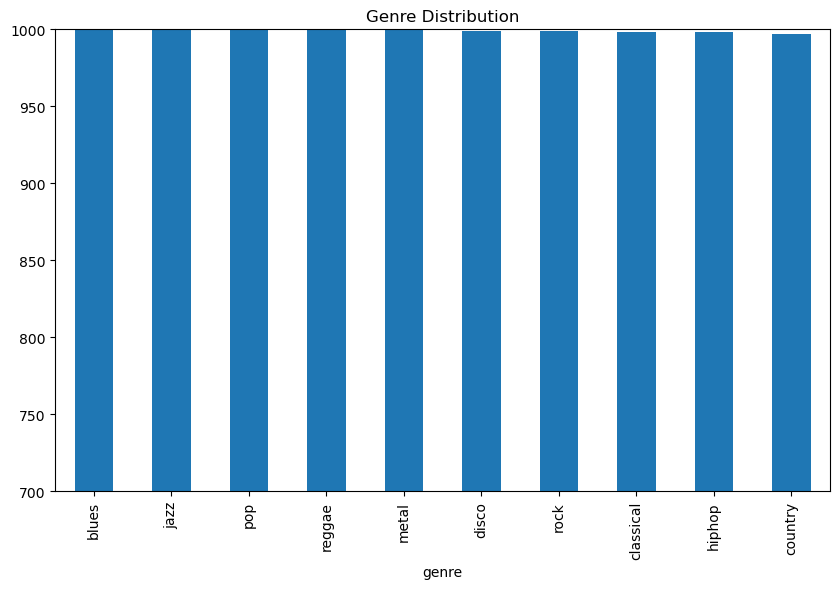

In [72]:
df['genre'].value_counts().plot(kind='bar', 
                                figsize=(10,6), 
                                title='Genre Distribution')
plt.ylim(700, df['genre'].value_counts().max())
plt.show()

### Boxplots

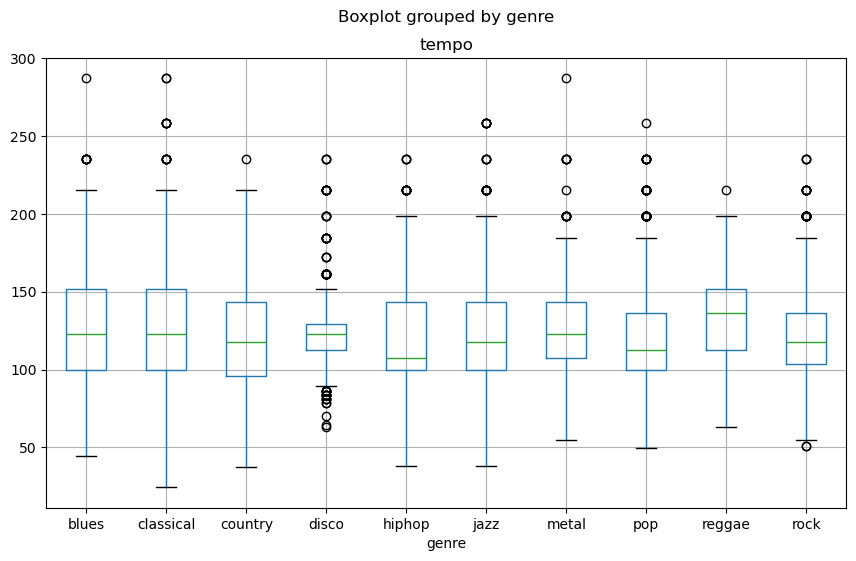

In [73]:
df.boxplot(column = 'tempo',
           by = 'genre', 
           figsize = (10, 6))
plt.show()

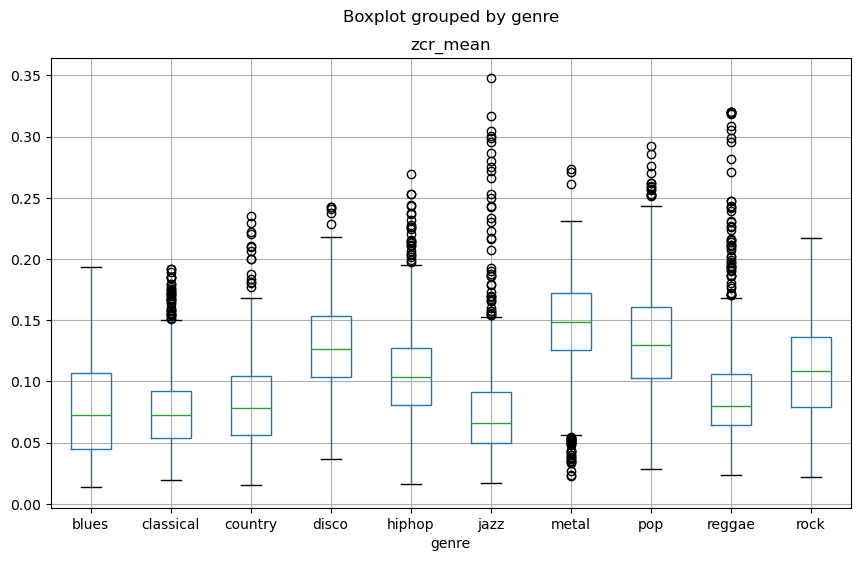

In [74]:
df.boxplot(column = 'zcr_mean',
           by = 'genre', 
           figsize = (10, 6))
plt.show()

### Scatter Plots

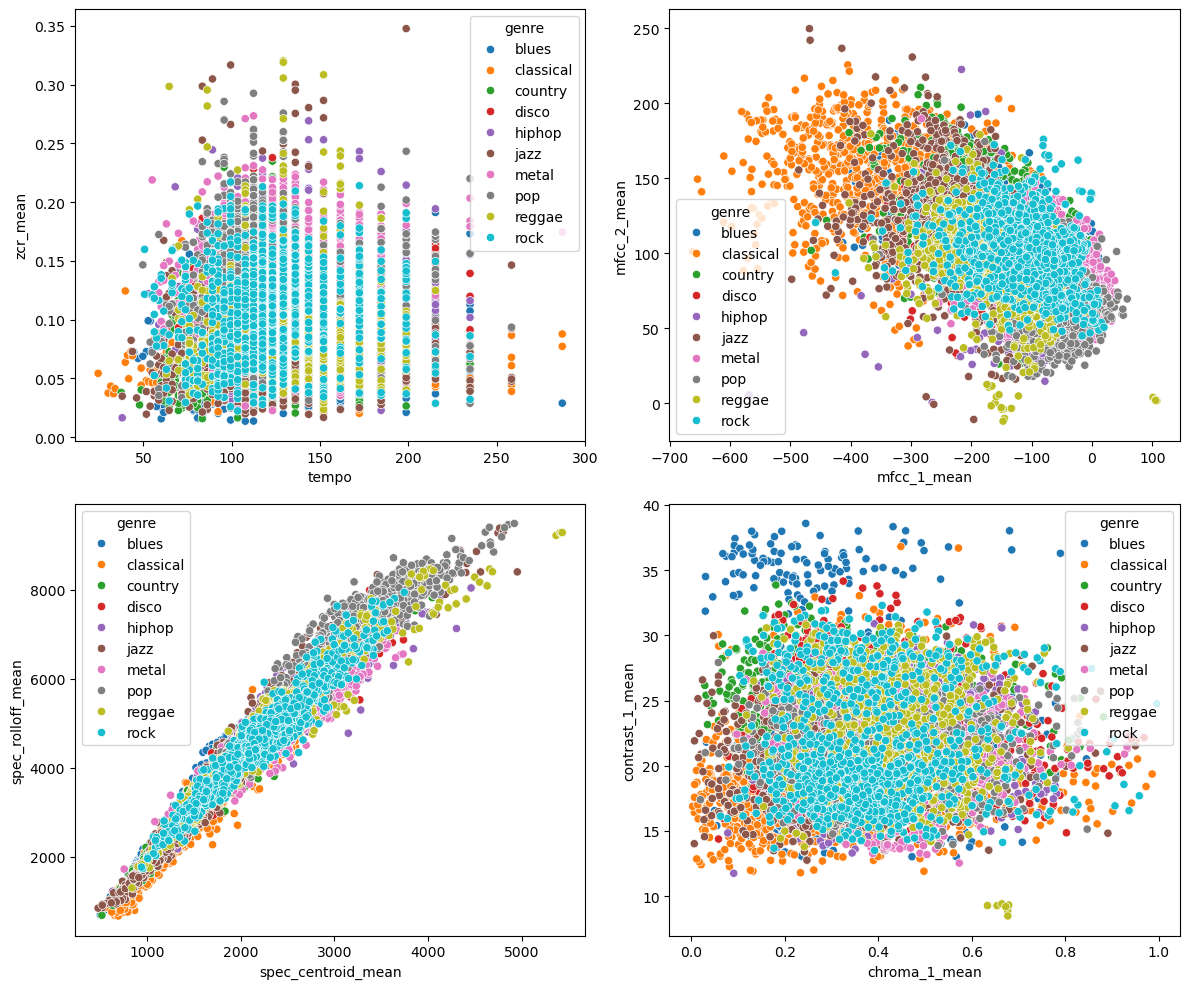

In [75]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(data=df, 
                x="tempo", 
                y="zcr_mean", 
                hue="genre", 
                ax=axes[0,0])

sns.scatterplot(data=df, 
                x="mfcc_1_mean", 
                y="mfcc_2_mean", 
                hue="genre", 
                ax=axes[0,1])

sns.scatterplot(data=df, 
                x="spec_centroid_mean", 
                y="spec_rolloff_mean", 
                hue="genre", 
                ax=axes[1,0])

sns.scatterplot(data=df, 
                x="chroma_1_mean", 
                y="contrast_1_mean", 
                hue="genre", 
                ax=axes[1,1])

f.tight_layout()
plt.show()

### Histograms

In [76]:
df_temp = df.copy()

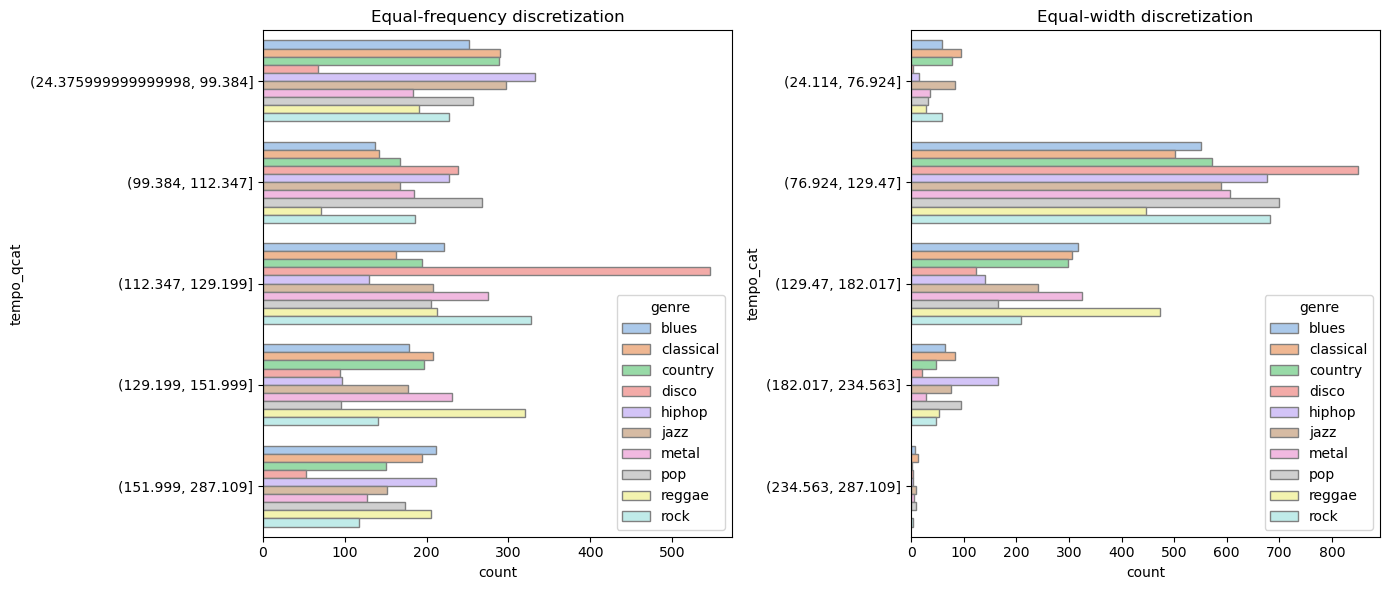

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Equal-frequency discretization
df_temp['tempo_qcat'], bins_q = pd.qcut(df['tempo'], 5, retbins=True)
sns.countplot(
    y="tempo_qcat",
    hue="genre",
    palette="pastel",
    edgecolor=".5",
    data=df_temp,
    ax=axes[0]
)
axes[0].set_title("Equal-frequency discretization")

# Equal-width discretization
df_temp['tempo_cat'], bins_w = pd.cut(df['tempo'], 5, retbins=True)
sns.countplot(
    y="tempo_cat",
    hue="genre",
    palette="pastel",
    edgecolor=".5",
    data=df_temp,
    ax=axes[1]
)
axes[1].set_title("Equal-width discretization")

plt.tight_layout()
plt.show()

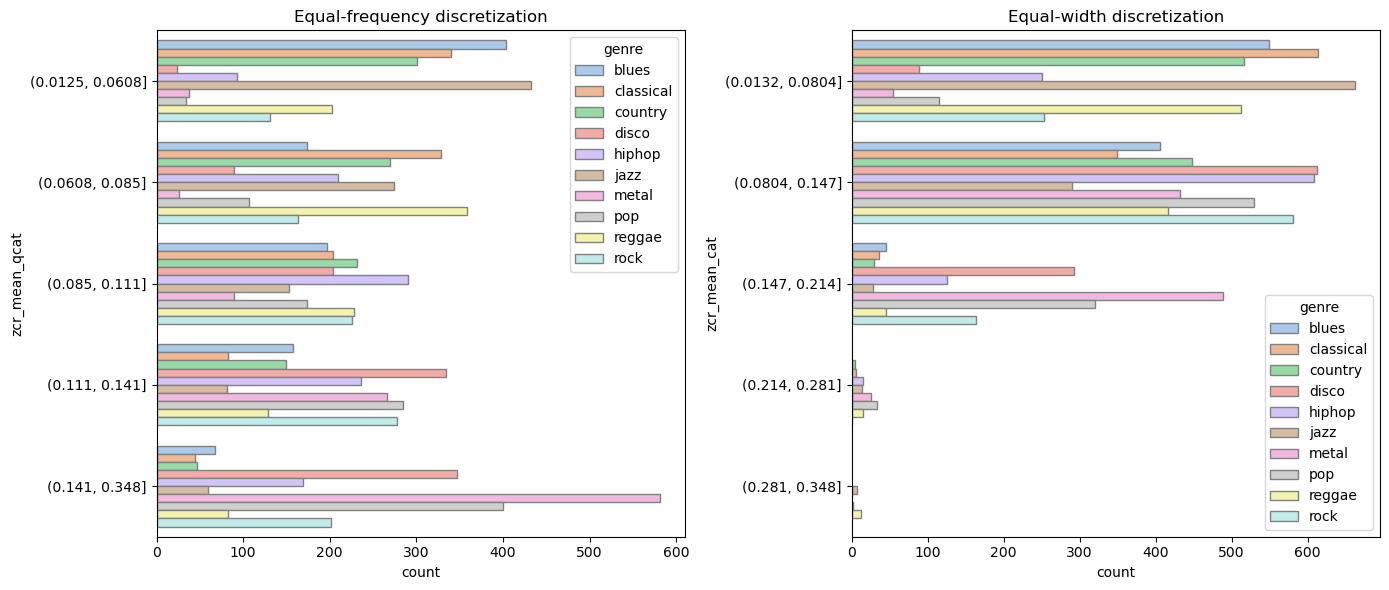

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Equal-frequency discretization
df_temp['zcr_mean_qcat'], bins_q = pd.qcut(df['zcr_mean'], 5, retbins=True)
sns.countplot(
    y="zcr_mean_qcat",
    hue="genre",
    palette="pastel",
    edgecolor=".5",
    data=df_temp,
    ax=axes[0]
)
axes[0].set_title("Equal-frequency discretization")

# Equal-width discretization
df_temp['zcr_mean_cat'], bins_w = pd.cut(df['zcr_mean'], 5, retbins=True)
sns.countplot(
    y="zcr_mean_cat",
    hue="genre",
    palette="pastel",
    edgecolor=".5",
    data=df_temp,
    ax=axes[1]
)
axes[1].set_title("Equal-width discretization")

plt.tight_layout()
plt.show()

In [79]:
df_temp.describe(include = 'category')

,tempo_qcat,tempo_cat,zcr_mean_qcat,zcr_mean_cat
count,9991,9991,9991,9991
unique,5,5,5,5
top,"(112.347, 129.199]","(76.924, 129.47]","(0.0125, 0.0608]","(0.0804, 0.147]"
freq,2485,6172,1999,4672


### Feature Correlation

In [80]:
feature_cols = df.columns.drop('genre') if 'genre' in df.columns else df.columns

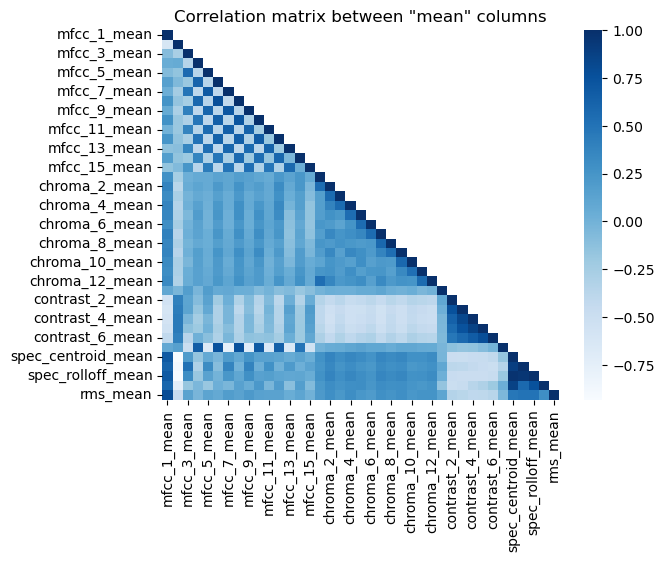

In [81]:
# Correlation matrix between "mean" columns
mean_cols = [col for col in feature_cols if 'mean' in col]
df_mean = df[mean_cols]
corr_mean = df_mean.corr()
corr_mean_lower = corr_mean.where(np.tril(np.ones(corr_mean.shape), k=0).astype(bool))

# plt.figure(figsize=(16, 12))
sns.heatmap(corr_mean_lower, cmap='Blues', annot=False)
plt.title("Correlation matrix between \"mean\" columns")
plt.show()

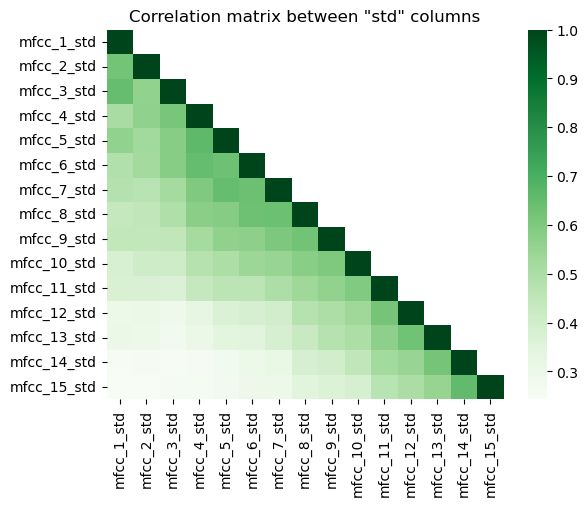

In [82]:
# Correlation matrix between "std" columns
std_cols = [col for col in feature_cols if 'std' in col]
df_std = df[std_cols]
corr_std = df_std.corr()
corr_std_lower = corr_std.where(np.tril(np.ones(corr_std.shape), k=0).astype(bool))

# plt.figure(figsize=(16, 12))
sns.heatmap(corr_std_lower, cmap='Greens', annot=False)
plt.title("Correlation matrix between \"std\" columns")
plt.show()

## Data Preprocessing
As previously shown, there are some highly correlated features in the dataset. With different preprocessing techniques we can reduce the amount of features to make the dataset lighter and increase classifier performances.

In [83]:
# Scaling numerical features

X = df.drop(columns='genre')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled.shape

(9991, 55)

### Data Reduction with PCA

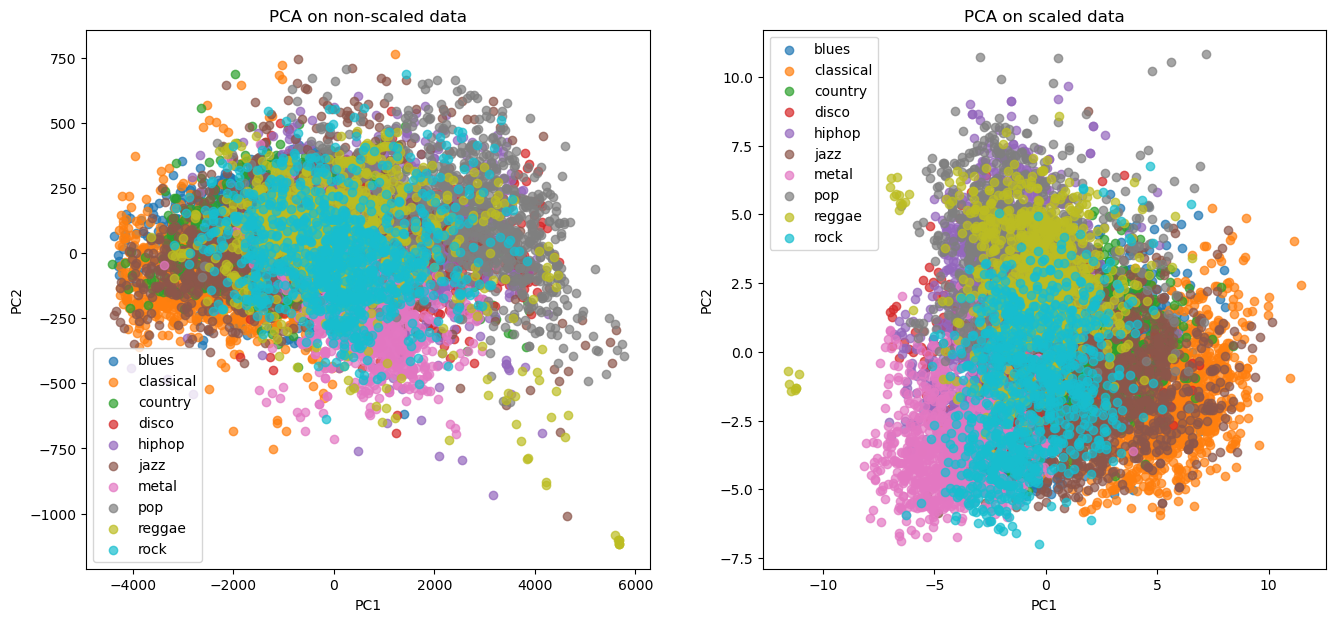

In [84]:
# Comparing PCA on non-scaled and scaled data

pca = PCA(n_components=2)
X_noscaled_pca = pca.fit_transform(X)
X_scaled_pca = pca.fit_transform(X_scaled)

df_noscaled = pd.DataFrame(X_noscaled_pca, columns=['PC1', 'PC2'])
df_noscaled['genre'] = df['genre'].values

df_scaled = pd.DataFrame(X_scaled_pca, columns=['PC1', 'PC2'])
df_scaled['genre'] = df['genre'].values

fig, axes = plt.subplots(1, 2, figsize=(16,7))

for g in df_noscaled['genre'].unique():
    subset = df_noscaled[df_noscaled['genre'] == g]
    axes[0].scatter(subset['PC1'], subset['PC2'], label=g, alpha=0.7)
axes[0].set_title('PCA on non-scaled data')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend()

for g in df_scaled['genre'].unique():
    subset = df_scaled[df_scaled['genre'] == g]
    axes[1].scatter(subset['PC1'], subset['PC2'], label=g, alpha=0.7)
axes[1].set_title('PCA on scaled data')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend()

plt.show()


In [85]:
# Feature reduction using PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['genre'] = df['genre'].values
df_pca.to_csv('../df/project_features_pca.csv', index=False)

X_pca.shape

(9991, 37)

In [86]:
# Feature reduction rateo

X_pca.shape[1] / X_scaled.shape[1] 

0.6727272727272727

In [87]:
# 5 Most important features for each of the 10 most influent PCA components

loadings = pd.DataFrame(pca.components_, columns=X.columns)
loadings.index = [f'PC{i+1}' for i in range(loadings.shape[0])]

top_features_per_pc = {}
for pc in loadings.index[:10]:  
    top_features = loadings.loc[pc].abs().sort_values(ascending=False).head(5).index.tolist()
    top_features_per_pc[pc] = top_features

for pc, features in top_features_per_pc.items():
    print(f"{pc}: {features}")

PC1: ['contrast_3_mean', 'contrast_4_mean', 'contrast_5_mean', 'mfcc_1_mean', 'contrast_2_mean']
PC2: ['mfcc_4_std', 'mfcc_6_std', 'mfcc_2_std', 'contrast_7_mean', 'mfcc_7_mean']
PC3: ['contrast_7_mean', 'mfcc_7_std', 'mfcc_11_std', 'mfcc_9_std', 'mfcc_8_mean']
PC4: ['zcr_mean', 'spec_centroid_mean', 'spec_rolloff_mean', 'mfcc_2_mean', 'mfcc_1_std']
PC5: ['mfcc_14_mean', 'mfcc_15_mean', 'mfcc_13_mean', 'contrast_1_mean', 'mfcc_12_mean']
PC6: ['chroma_10_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_11_mean', 'chroma_5_mean']
PC7: ['mfcc_3_mean', 'chroma_10_mean', 'contrast_1_mean', 'chroma_9_mean', 'mfcc_6_mean']
PC8: ['chroma_6_mean', 'chroma_1_mean', 'chroma_7_mean', 'chroma_2_mean', 'mfcc_11_mean']
PC9: ['chroma_3_mean', 'chroma_1_mean', 'chroma_4_mean', 'chroma_10_mean', 'chroma_6_mean']
PC10: ['contrast_1_mean', 'chroma_1_mean', 'rms_mean', 'mfcc_1_mean', 'mfcc_1_std']


## Classification

In [88]:
# To avoid running previous code

df = pd.read_csv("../df/project_features.csv")
df_pca = pd.read_csv("../df/project_features_pca.csv")

### Confusion Matrix

### Recursive Feature Elimination

## Model Selection